# Backtesting a cross-sectional mean reversion trading strategy

In this notebook, we will backtest a cross-sectional mean reversion trading strategy, taken from Ernest Chan's book [Algorithmic Trading: Winning Strategies and Their Rationale](https://www.amazon.com/Algorithmic-Trading-Winning-Strategies-Rationale/dp/1118460146/ref=sr_1_1?keywords=Algorithmic+Trading%3A+Winning+Strategies+and+Their+Rationale&qid=1560084760&s=books&sr=1-1).

I suggest for anyone looking to to get into algorithmic trading to also read Chan's other book [Quantitative Trading: How to Build Your Own Algorithmic Trading Business](https://www.amazon.co.uk/Quantitative-Trading-Build-Algorithmic-Business/dp/0470284889).


## What is a mean reversion strategy?
Mean-reversion strategies work on the assumption that there is an underlying stable trend in the price of an asset and prices fluctuate randomly around this trend. Therefore, values deviating far from the trend will tend to reverse direction and revert back to the trend. That is, if the value is unusually high, we expect it to go back down and if it is unusually low, go back up. <br>
![image](Images/mean_reversion.png)

A cross-sectional mean reversion strategy extends on this, by proposing that stocks behave like the stocks they are *historically* correlated to.
![](Images/cross_mean_reversion.png)

The strategy described in Chan’s book is as follows: Everyday, every stock *i* in the universe is assigned a weight *w_i* according to the following formula: <br>
![](Images/formula.png)<br>

Where *r_m* is the mean returns of the universe. This weight will tell us how much of the portfolio will be long or short that particular stock. As we can see in the formula, the farther an individual stock’s returns are from the mean, the greater its weight will be.

In [5]:
#import needed libraries
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import backtrader as bt
from datetime import datetime

%matplotlib inline
sns.set()

# Data
For this analysis, we consider the S&P 500 stocks as our universe. We will use *pandas_datareader* module to download stocks from [IEX](https://iextrading.com/), you can also use yahoo finance.

In [32]:
#Load in your data from

data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
table = data[0]
tickers = table['Symbol'].to_list()
pd.Series(tickers).to_csv("../data/tickers.csv")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In order to speed up this process, use the python's multi-threading __*concurrent.futures.ThreadPoolExecutor*__

In [53]:
%%time
from concurrent import futures

end = datetime.now()
start = datetime(end.year - 5, end.month , end.day)
bad = []

def download(ticker):
    df = web.DataReader(ticker,'Quandl', start, end)
    df.to_csv(f"../data/ticks/{ticker}.csv")

#with futures.ThreadPoolExecutor(50) as executor:
#    res = executor.map(download, tickers)

CPU times: user 58 µs, sys: 0 ns, total: 58 µs
Wall time: 107 µs


In [54]:
download('AAPL')

NotImplementedError: data_source='Quandl' is not implemented

In [45]:
with futures.ThreadPoolExecutor(100) as executor:
    executor.map(download, tickers)

Next define the strategy:

In [39]:
class CrossSectionalMR(bt.Strategy):
    def prenext(self):
        self.next()

    def next(self):
        # only look at data that existed yesterday
        available = list(filter(lambda d: len(d), self.datas))

        rets = np.zeros(len(available))
        for i, d in enumerate(available):
            # calculate individual daily returns
            rets[i] = (d.close[0]- d.close[-1]) / d.close[-1]

        # calculate weights using formula
        market_ret = np.mean(rets)
        weights = -(rets - market_ret)
        weights = weights / np.sum(np.abs(weights))

        for i, d in enumerate(available):
            self.order_target_percent(d, target=weights[i])

Now backtest the strategy using [Backtrader](https://www.backtrader.com/), assuming 1m of initial capital:

In [40]:
cerebro = bt.Cerebro(stdstats=False)
cerebro.broker.set_coc(True)

for ticker in tickers:
    data = bt.feeds.GenericCSVData(
        fromdate=start,
        todate=end,
        dataname=f"tickers/{ticker}.csv",
        dtformat=('%Y-%m-%d'),
        openinterest=-1,
        nullvalue=0.0,
        plot=False
    )
    cerebro.adddata(data)

cerebro.broker.setcash(1_000_000)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addstrategy(CrossSectionalMR)
results = cerebro.run()

FileNotFoundError: [Errno 2] No such file or directory: 'tickers/MMM.csv'

Sharpe: 1.111
Norm. Annual Return: 7.35%
Max Drawdown: 6.92%


<IPython.core.display.Javascript object>

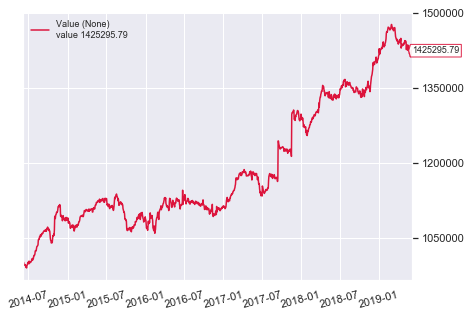

In [6]:
print(f"Sharpe: {results[0].analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")
print(f"Norm. Annual Return: {results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%")
print(f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")
cerebro.plot()[0][0]

# Results
Not bad! The strategy returns a Sharpe ratio of 1.084 with an  normalised annual return of %7.50. While not much better than buying and holding an SPY index, the volatility is greatly reduced (as noted by the drawdown amount). <br>

A few points to take into account with this strategy, (before planning your retirement in Barbados!):<br>

* __Transaction costs__: We have assumed 0 transaction costs for every trade in this strategy, adding this in will dramatically change the strategy. This can be countered by altering the trade strategy to only buy/sell the most volatile moves, rather than all moves.<br> 

* __Survivorship bias__: The dataset does not take into account companies that have moved in/out of the S&P index in the time period we backtested for. Using a survivorship bias free data-set will ensure the backtest results are more robust. <br>

* __Capital__: Since every stock is being traded in this strategy, the investor will need a large initial outlay for the strategy to work.<br>